# Simplest model

Assumptions:
* 2D motion
* Gyroscope gives an angle output without any drift
* Inertial frame is aligned with world frame (robot starts at $\theta = 0$)

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sp.init_printing()

In [2]:
# defines a few variables
x, y, xdot, ydot, theta = sp.symbols('x y v_x v_y theta')
state = [x, y, theta, xdot, ydot]
a_x, a_y = sp.symbols('a_x a_y') # in body frame
dt = sp.symbols('Delta_t')

## Dynamic model

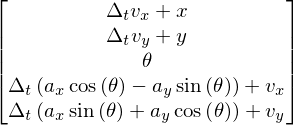

In [3]:
dx = sp.Matrix([xdot, ydot, 0, sp.cos(theta) * a_x - sp.sin(theta) * a_y, sp.sin(theta) * a_x + sp.cos(theta) * a_y])
g = sp.Matrix(state) + dt * dx
g

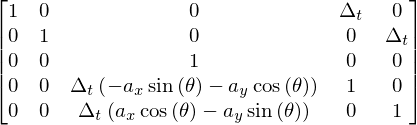

In [4]:
G = g.jacobian(state)
G

# Measurement function

For this model, we define two measurement functions:

1. The first one is just giving the angle, as output by the MPU9250's integrated processor
2. The second one represents the distance to a beacon

In [5]:
h_dmp = sp.Matrix([theta])
h_dmp

In [6]:
H_dmp = h_dmp.jacobian(state)
H_dmp

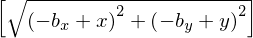

In [7]:
# Generate the measurement function for beacons
b_x, b_y = sp.symbols('b_x b_y') # beacon position
h_b = sp.Matrix([sp.sqrt((x - b_x)**2 + (y - b_y)**2)])
h_b

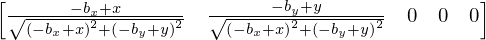

In [8]:
H_b = h_b.jacobian(state)
H_b

# Simulation

In [9]:
from simple_model import SimpleModel
import trajectories

BEACON_POS = [
    (-1.5, 0),
    (1.5, 1),
    (1.5, -1),
]

dt = 1 / 200

Q_b = np.array([[10]])
Q_theta = np.array([[0.1]])
R = np.diag([0.1, 0.1, 0.1, 0.1, 0.1])
estimator = SimpleModel(dt, R, Q_theta, Q_b)

In [13]:
angle, angle_estimated, angle_measured = [], [], []
x, xhat = [], []
y, yhat = [], []
acc = []
ts = []

for i, p in zip(range(10000), trajectories.generate_circular_traj(1, np.deg2rad(20), dt)):
    ts.append(p.timestamp)
    
    # control input
    u = np.array([p.acc[0], p.acc[1]]) + np.random.normal(0, 0.2, 2)
    acc.append(u)
    estimator.predict(u)
    
    # Angle measurement
    z = p.theta + np.random.normal(0, 0.1)
    estimator.correct_angle(z)
    angle_measured.append(z)
    
    # Beacon update
    if i % 100 == 0:
        for bx, by in BEACON_POS:
            distance = np.sqrt((p.pos[0]-bx)**2+(p.pos[1]-by)**2)
            z = distance + np.random.normal(0, 0.03)
            estimator.correct_beacon(bx, by, z)

    angle.append(p.theta)
    angle_estimated.append(estimator.theta)
    
    xhat.append(estimator.x)
    x.append(p.pos[0])
    
    yhat.append(estimator.y)
    y.append(p.pos[1])


## Results

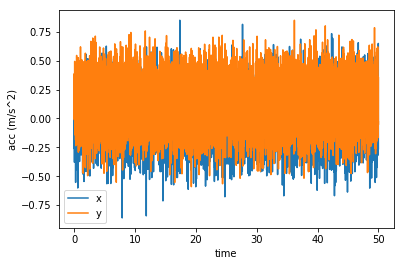

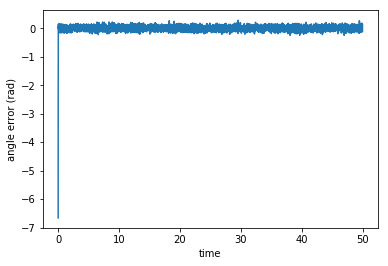

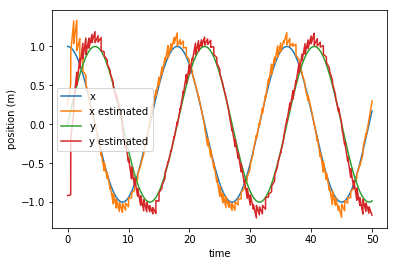

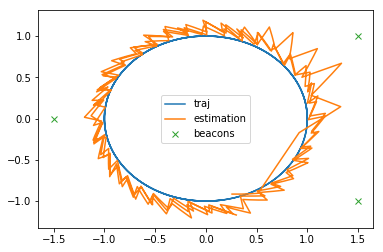

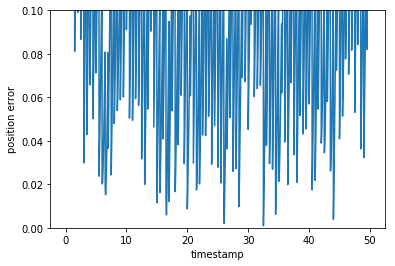

In [14]:
plt.plot(ts, [s[0] for s in acc])
plt.plot(ts, [s[1] for s in acc])
plt.xlabel('time')
plt.ylabel('acc (m/s^2)')
plt.legend(['x', 'y'])
plt.show()

plt.plot(ts, [a-b for a, b in zip(angle, angle_estimated)])
plt.xlabel('time')
plt.ylabel('angle error (rad)')
plt.show()

plt.plot(ts, x)
plt.plot(ts, xhat)
plt.plot(ts, y)
plt.plot(ts, yhat)
plt.xlabel('time')
plt.ylabel('position (m)')
plt.legend(('x', 'x estimated', 'y', 'y estimated'))
plt.show()

plt.plot(x, y)
plt.plot(xhat, yhat)
plt.plot([x for x, y in BEACON_POS],[y for x, y in BEACON_POS], 'x')
plt.legend(('traj', 'estimation', 'beacons'))
plt.show()

plt.plot(ts, [np.sqrt((x-xh)**2+(y-yh)**2) for x,xh,y,yh in zip(x, xhat,y,yhat)])
plt.ylim(0., 0.1)
plt.xlabel('timestamp')
plt.ylabel('position error')
plt.show()